시계열

In [31]:
import pandas as pd

df = pd.read_csv('MD2_input_predicted_located_filled.csv')

C:\Users\user\AppData\Local\Temp\ipykernel_21156\4244129558.py:3: DtypeWarning: Columns (32,86,123) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('MD2_input_predicted_located_filled.csv')


파생변수

In [32]:
# 실질 LTV
df['effective_LTV'] = df['전세_환산가(만원)'] / df['Predicted_Price'] * 100


# 리스크 차액
df['deposit_overhang'] = df['전세_환산가(만원)'] - df['Predicted_Price']


# 잔차 비율
df['Residual_pct'] = df['Residual'] / df['Predicted_Price']

공간 자기상관

In [21]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


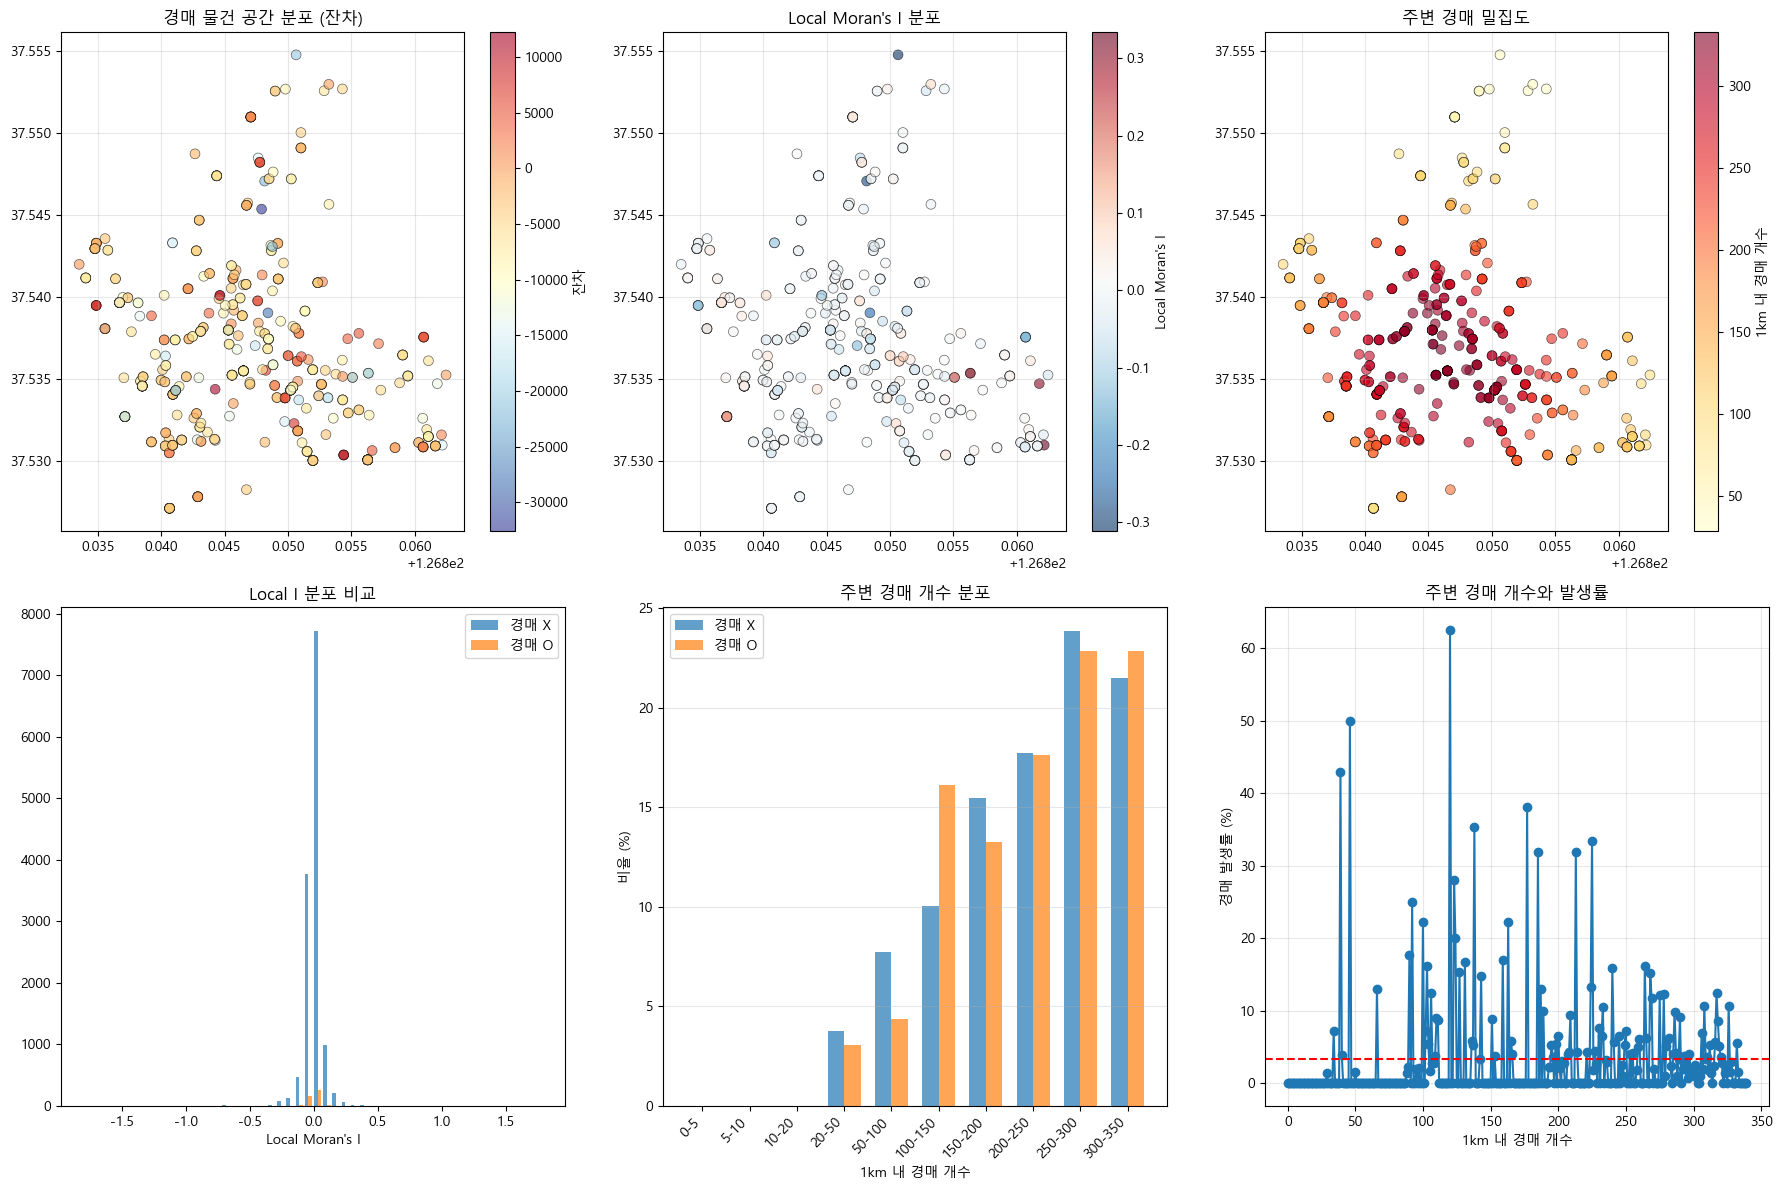


✅ 완료: local_morans_i, nearby_auction_1km 컬럼 추가됨


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from scipy import stats
import matplotlib.pyplot as plt

# ====================================
# 통합: Local Moran's I + 1km 경매 개수 + 시각화
# ====================================

def calculate_local_morans_for_all(df, threshold_km=0.5):
    """전체 거래 Local Moran's I + 1km 내 경매 개수"""
    n = len(df)
    df_clean = df.dropna(subset=['경도', '위도', 'Residual']).copy()
    
    coords = df_clean[['경도', '위도']].values
    residuals = df_clean['Residual'].values
    auction_flags = df_clean['경매_4년이내'].values
    
    # 거리 계산
    coords_scaled = coords.copy()
    coords_scaled[:, 0] *= 88
    coords_scaled[:, 1] *= 111
    distances = cdist(coords_scaled, coords_scaled)
    
    local_i_values = []
    auction_neighbor_counts = []
    
    for i in range(len(df_clean)):
        neighbors = (distances[i, :] < threshold_km) & (distances[i, :] > 0)
        neighbor_count = neighbors.sum()
        
        # 1km 내 경매 물건 개수
        auction_neighbors = neighbors & (auction_flags == 1)
        auction_neighbor_counts.append(auction_neighbors.sum())
        
        if neighbor_count == 0:
            local_i_values.append(np.nan)
            continue
        
        # Local Moran's I
        neighbor_distances = distances[i, neighbors]
        weights = 1 / neighbor_distances
        weights = weights / weights.sum()
        
        residual_mean = residuals.mean()
        residual_std = residuals.std()
        
        z_i = (residuals[i] - residual_mean) / residual_std
        z_neighbors = (residuals[neighbors] - residual_mean) / residual_std
        
        local_i = z_i * np.sum(weights * z_neighbors)
        local_i_values.append(local_i)
    
    df_clean['local_morans_i'] = local_i_values
    df_clean['nearby_auction_1km'] = auction_neighbor_counts
    
    return df_clean

# 실행
df_with_local_i = calculate_local_morans_for_all(df, threshold_km=1.0)

# 원본에 병합
df = df.merge(
    df_with_local_i[['local_morans_i', 'nearby_auction_1km']], 
    left_index=True, right_index=True, how='left'
)

# ====================================
# 시각화 (위 코드 스타일)
# ====================================

df_auction = df_with_local_i[df_with_local_i['경매_4년이내'] == 1]

fig = plt.figure(figsize=(18, 12))

# 1. 공간 분포 (잔차)
ax1 = plt.subplot(2, 3, 1)
scatter = ax1.scatter(df_auction['경도'], df_auction['위도'], 
                     c=df_auction['Residual'], cmap='RdYlBu_r', 
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, ax=ax1, label='잔차')
ax1.set_title('경매 물건 공간 분포 (잔차)')
ax1.grid(True, alpha=0.3)

# 2. Local Moran's I
ax2 = plt.subplot(2, 3, 2)
scatter = ax2.scatter(df_auction['경도'], df_auction['위도'], 
                     c=df_auction['local_morans_i'], cmap='RdBu_r', 
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, ax=ax2, label='Local Moran\'s I')
ax2.set_title('Local Moran\'s I 분포')
ax2.grid(True, alpha=0.3)

# 3. 1km 내 경매 개수
ax3 = plt.subplot(2, 3, 3)
scatter = ax3.scatter(df_auction['경도'], df_auction['위도'], 
                     c=df_auction['nearby_auction_1km'], cmap='YlOrRd', 
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, ax=ax3, label='1km 내 경매 개수')
ax3.set_title('주변 경매 밀집도')
ax3.grid(True, alpha=0.3)

# 4-6: 아래 코드 스타일 차트 (경매 비교)
g1 = df_with_local_i[df_with_local_i['경매_4년이내'] == 1]
g0 = df_with_local_i[df_with_local_i['경매_4년이내'] == 0]

# 4. Local I 분포
ax4 = plt.subplot(2, 3, 4)
ax4.hist([g0['local_morans_i'].dropna(), g1['local_morans_i'].dropna()], 
         bins=50, label=['경매 X', '경매 O'], alpha=0.7)
ax4.set_xlabel('Local Moran\'s I')
ax4.legend()
ax4.set_title('Local I 분포 비교')

# 5. 경매 개수 분포
ax5 = plt.subplot(2, 3, 5)

# 의미있는 구간으로 묶기
bins_custom = [0, 5, 10, 20, 50, 100, 150, 200, 250, 300, 350]

g0_counts, bins = np.histogram(g0['nearby_auction_1km'], bins=bins_custom)
g1_counts, _ = np.histogram(g1['nearby_auction_1km'], bins=bins_custom)

g0_pct = g0_counts / len(g0) * 100
g1_pct = g1_counts / len(g1) * 100

x_pos = np.arange(len(bins) - 1)
width = 0.35

ax5.bar(x_pos - width/2, g0_pct, width, label='경매 X', alpha=0.7)
ax5.bar(x_pos + width/2, g1_pct, width, label='경매 O', alpha=0.7)

# x축 라벨
bin_labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
ax5.set_xticks(x_pos)
ax5.set_xticklabels(bin_labels, rotation=45, ha='right')
ax5.set_ylabel('비율 (%)')
ax5.set_xlabel('1km 내 경매 개수')
ax5.set_title('주변 경매 개수 분포')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. 경매 개수-발생률 관계
ax6 = plt.subplot(2, 3, 6)
nearby_counts = range(0, int(df_with_local_i['nearby_auction_1km'].max()) + 1)
auction_rates = [
    df_with_local_i[df_with_local_i['nearby_auction_1km'] == c]['경매_4년이내'].mean() * 100
    if len(df_with_local_i[df_with_local_i['nearby_auction_1km'] == c]) > 0 else 0
    for c in nearby_counts
]
ax6.plot(nearby_counts, auction_rates, marker='o')
ax6.axhline(df_with_local_i['경매_4년이내'].mean()*100, color='red', linestyle='--')
ax6.set_xlabel('1km 내 경매 개수')
ax6.set_ylabel('경매 발생률 (%)')
ax6.set_title('주변 경매 개수와 발생률')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n완료: local_morans_i, nearby_auction_1km 컬럼 추가됨")

In [50]:
df.to_csv('MD2_final.csv', index=False)

In [49]:
df.columns

Index(['PNU', '계약일자', '전월세구분', '전용면적(㎡)', '보증금(만원)', '보증금_증감률(%)', '월세금(만원)',
       '전세_환산가(만원)', '층', '계약기간_일수', '계약구분', '종전계약 보증금(만원)', '종전계약 월세(만원)',
       '건축연령', '_deposit_num', '_monthly_num', '전월세_평균_보증금(만원)',
       '전월세_평균_월세(만원)', '전월세_건수', '전용면적(㎡)_md1', '대지권면적(㎡)', '계약일', '거래금액(만원)',
       '층_md1', '거래유형', '관내', '매수자_M', '매수자_개인', '매수자_공공기관', '매수자_기타',
       '매수자_법인', '매도자_M', '매도자_개인', '매도자_공공기관', '매도자_기타', '매도자_법인', '등기일자',
       '건축연령_md1', '계약기간', '거래유형_중개거래', '거래유형_직거래', '전월세_건수_md1',
       '전월세_평균_보증금(만원)_md1', '전월세_평균_월세(만원)_md1', '전월세_최근계약일', '대지위치', '동명칭',
       '대지면적(㎡)', '건축면적(㎡)', '연면적(㎡)', '지상층수', '지하층수', '세대수(세대)', '공원_최단거리',
       '공원_개수', '교육_최단거리', '교육_개수', '유통_최단거리', '유통_개수', '계약일_파싱', '계약월',
       '기준금리(연%)', '전용면적_평', 'price_per_pyeong', 'ln_거래금액', '건축연령_sq',
       'area_floor_inter', '매수자_법인_flag', 'age_buycorp_inter', 'Predicted_ln',
       'Predicted_Price', 'Actual_Price', 'Residual', '위도', '경도', '경매_4년이내',
       'effective_LTV', 'deposit_